In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt

# Aux basis functions
def interp1(grid, x, f, axis=0):  # Linear interpolation
    s = torch.ones(f.dim(), dtype=torch.long)
    s[axis] = x.numel()
    s = torch.Size(s)
    ind = torch.searchsorted(grid, x) # indices on the right of x
    ind = torch.minimum(torch.maximum(ind, torch.tensor(1, device=ind.device)), torch.tensor(grid.numel()-1, device=ind.device))
    gr = grid[ind].view(s)
    gl = grid[ind-1].view(s)
    fr = torch.index_select(f,axis,ind)
    fl = torch.index_select(f,axis,ind-1)
    xt = x.view(s)
    return (fr * (xt - gl) + fl * (gr - xt)) / (gr - gl)

def linearMass(grid):   # Mass matrix of piecewise linear functions
    h = grid[1:] - grid[:-1]
    h = torch.cat([h[0].reshape(1), h, h[-1].reshape(1)])
    M = torch.diag(h[1:-1]/6, -1) + torch.diag(h[1:-1]/6, 1) + torch.diag((h[:-1]+h[1:])/3)
    M[0,0] = h[1]/3 
    M[-1,-1] = h[-1]/3
    return M

def linearLap(grid):    # Laplacian matrix of piecewise linear functions
    h = grid[1:] - grid[:-1]
    h = torch.cat([h[0].reshape(1), h, h[-1].reshape(1)])
    M = torch.diag(-1/h[1:-1], -1) + torch.diag(-1/h[1:-1], 1) + torch.diag(1/h[:-1]+1/h[1:])
    M[0,0] = 1/h[1]
    M[-1,-1] = 1/h[-1]
    return M

# Aux cross functions
def maxvol2(A, niters=100, eps=1e-2):
    """
    Maxvol algorithm for selecting the most important rows of a matrix
    """
    LU, piv, _ = torch.linalg.lu_factor_ex(A)   
    ind = torch.arange(A.shape[0], device=A.device)
    for i,p in enumerate(piv-1): # Swap rows
        ind[i], ind[p] = ind[p]+0, ind[i]+0
    ind = ind.index_select(0, torch.arange(A.shape[1], device=A.device))
    B = torch.linalg.solve(A.index_select(0, ind), A, left=False)
    for _ in range(niters):
        big_ind = torch.argmax(torch.abs(B))
        i0, j0 = torch.unravel_index(big_ind, A.shape)
        Bi = B.index_select(0, i0)
        Bj = B.index_select(1, j0)
        Bij = Bi.index_select(1, j0)
        if torch.abs(Bij) <= 1 + eps:
            break
        k = ind.index_select(0, j0)
        Bk = B.index_select(0, k)
        B += Bj * ((Bk - Bi) / Bij)
        ind[j0] = i0        
    return ind

def qrmaxvol(yc, yn, dir, z=None):
    """
    Move non-orth center between the TT cores, computing enrich, QR and maxvol
    """
    r0, n, r1 = yc.shape
    if dir > 0:
        yc = yc.reshape(r0*n, r1)
    else:
        yc = yc.reshape(r0, n*r1).T
    if z is not None:
        yc = torch.hstack([yc, z])

    yq, rv = torch.linalg.qr(yc, mode='reduced')
    rv = rv.index_select(1, torch.arange(yc.shape[1], device=yc.device))
    ind = maxvol2(yq)
    YY = yq.index_select(0, ind)
    yq = torch.linalg.solve(YY, yq, left=False)
    rv = YY @ rv

    if yn is not None:
        rnrb = list(yn.shape)
        if dir > 0:
            yn = yn.reshape(rnrb[0], -1)
            yn = rv @ yn
            rnrb[0] = rv.shape[0]
        else:
            yn = yn.reshape(-1, rnrb[-1])
            yn = yn @ rv.T
            rnrb[-1] = rv.shape[0]
        yn = yn.reshape(rnrb)

    if dir > 0:
        yc = yq.reshape(r0, n, -1)
    else:
        yc = (yq.T).reshape(-1, n, r1)
    return yc, yn, ind

def indexmerge(X1, X2, X3=None):
    """
    Merge indices with direct sum
    """
    Y = X2.reshape(1, X2.shape[0], 1, X2.shape[1])
    if X1 is not None:
        X1 = X1.reshape(X1.shape[0], 1, 1, X1.shape[1])
        X1 = torch.tile(X1, [1, Y.shape[1], 1, 1])
        Y = torch.tile(Y, [X1.shape[0], 1, 1, 1])
        Y = torch.cat([X1, Y], dim=3)
    if X3 is not None:
        X3 = X3.reshape(1, 1, X3.shape[0], X3.shape[1])
        X3 = torch.tile(X3, [Y.shape[0], Y.shape[1], 1, 1])
        Y = torch.tile(Y, [1, 1, X3.shape[2], 1])
        Y = torch.cat([Y, X3], dim=3)
    return Y.reshape(-1, Y.shape[-1])

def ind2samples(grid, ind):
    """
    Convert indices to samples on the grid
    """
    return torch.hstack([grid[i][indi].reshape(-1,1) for i, indi in enumerate(ind.T)])

def evaluate_core(fun, Jl, ii, Jr, Ui, grid, dir):
    """
    Evaluate function for one TT core
    """
    X = ind2samples(grid, indexmerge(Jl, ii, Jr))
    Y = fun(X)
    # if dir < 0:
        # Y = Y.T
    Y = Y.reshape(Ui.shape)
    return Y, X.shape[0], torch.norm(Y - Ui)/torch.norm(Y)


def start_stop_pos(d, dir):
    """
    Start, end and next dimensions for the cross
    """
    if dir > 0:
        return 0, d-1, 1
    else:
        return d-1, 0, 0


# Aux MCMC functions
def hellinger(lFex, lFapp):
    """
    Hellinger distance between two densities
    lFex: log(exact density Fex), can be unnormalised
    lFapp: log(approximate density Fapp), must be normalised
    """
    dF = lFex - lFapp
    dF = dF - torch.max(dF)
    lZex = torch.log(torch.mean(torch.exp(dF))) # up to  +max(dF) which cancels below anyway
    H = torch.mean( (torch.exp(0.5*(dF-lZex)) - 1)**2 )
    return torch.sqrt(H/2)

def mcmc_prune(z, lFex, lFapp):
    num_of_rejects = 0
    for i in range(lFapp.numel()-1):
        alpha = lFex[i+1] - lFapp[i+1] - lFex[i] + lFapp[i]
        if torch.exp(alpha) < torch.rand(1):
            # Reject
            z[i+1] = z[i].clone()
            lFapp[i+1] = lFapp[i].clone()
            lFex[i+1] = lFex[i].clone()
            num_of_rejects += 1
    print(f"mcmc_prune completed with {num_of_rejects} rejections ({num_of_rejects*100.0/lFapp.numel()}%)")
    return z, lFex, lFapp, num_of_rejects

def randref(reference_sigma, shape, device='cpu'):
    """
    Generate random samples from a truncated normal or uniform distribution
    """
    if reference_sigma == 0:
        return torch.rand(shape, device=device)
    else:
        cdf_ifactor = torch.erf(reference_sigma/torch.sqrt(torch.tensor(2.0))) / 0.5
        return torch.erfinv((torch.rand(shape, device=device)-0.5)*cdf_ifactor)*torch.sqrt(torch.tensor(2.0))
    

# Classes
class TT(nn.Module): # Discrete TT(i) = <U, e_i> for general purpose with MSE loss
    def __init__(self, n=[1], r=[1,1], device='cpu', requires_grad=True):
        super().__init__()
        if requires_grad:
            self.U = nn.ParameterList([nn.Parameter(torch.rand(r[i], n[i], r[i + 1], device=device)*1e-3) for i in range(len(n))])
        else:
            self.U = [torch.rand(r[i], n[i], r[i + 1], device=device)*1e-3 for i in range(len(n))]

    def loss(self, X, Y):
        return torch.mean((self.forward(X) - Y)**2)        
    

class TTLin(TT): # Linear TT(x) = <U, \phi(x)> for general purpose with MSE loss
    def __init__(self, grid=[torch.ones(1)], r=[1,1], requires_grad=True):
        super().__init__(n=[g.numel() for g in grid], r=r, device=grid[0].device, requires_grad=requires_grad)
        self.grid = grid

    def interp_core(self, k, x):
        return interp1(self.grid[k], x, self.U[k], axis=1)
    
    def forward(self, X):
        prod = self.interp_core(0, X[:,0])
        for k in range(1, len(self.U)):
            prod = torch.einsum('ijk,kjl->ijl', prod, self.interp_core(k, X[:,k]))
        return prod
    
    def cross(self, fun, tol=1e-6, nswp=20, kickrank=4, dir=1):
        """
        Fixed-rank cross approximation
        fun should take samples of shape (M, d) and return a tensor of shape (M, m)
        """
        d = len(self.U)
        n = [g.numel() for g in self.grid]
        # Initial QR - goes in the reverse of dir
        istart, iend, inext = start_stop_pos(d, -dir) # Where we start and move next
        J = [None]*(d+1)
        for i in range(istart, iend, -dir):
            self.U[i], self.U[i-dir], ind = qrmaxvol(self.U[i], self.U[i-dir], -dir)
            # Restrict new indices
            ii = torch.arange(n[i], device=self.U[i].device).reshape(-1,1)
            if -dir > 0:
                J[i+inext] = indexmerge(J[i], ii, None)
            else:
                J[i+inext] = indexmerge(None, ii, J[i+1])
            J[i+inext] = J[i+inext].index_select(0, ind) # [ind, :]
        # # Initial indices
        # if (dir>0):
        #     J = [None]+[torch.randint(low=0, high=self.U[i].shape[1], size=(self.U[i].shape[0],len(self.U)-i), device=self.U[0].device) for i in range(1,len(self.U))]+[None]

        evalcnt = 0
        for swp in range(nswp):
            istart, iend, inext = start_stop_pos(d, dir) # Where we start and move next
            max_err = 0            
            for i in range(istart, iend, dir):
                ii = torch.arange(n[i], device=self.U[i].device).reshape(-1,1)
                # Sample
                self.U[i], devalcnt, err = evaluate_core(fun, J[i], ii, J[i+1], self.U[i], self.grid, dir)
                evalcnt += devalcnt
                max_err = max(max_err, err)
                print(f"\t swp = {swp}.{i}: err = {err:.3e}, #evals = {devalcnt}")
                # Move non-orth center
                self.U[i], self.U[i+dir], ind = qrmaxvol(self.U[i], self.U[i+dir], dir)
                # Restrict new indices
                if dir > 0:
                    J[i+inext] = indexmerge(J[i], ii, None)
                else:
                    J[i+inext] = indexmerge(None, ii, J[i+1])
                J[i+inext] = J[i+inext].index_select(0, ind) # [ind, :]

            print(f"Cross sweep {swp}: max_err = {max_err:.3e}, cum#evals = {evalcnt}")
            if max_err < tol:
                break
            if swp==nswp-1: # Last core needs to be computed
                i = i+dir
                ii = torch.arange(n[i], device=self.U[i].device).reshape(-1,1)
                self.U[i], devalcnt, err = evaluate_core(fun, J[i], ii, J[i+1], self.U[i], self.grid, dir)
                evalcnt += devalcnt
                print(f"\t swp = {swp}.{i}: err = {err:.3e}, #evals = {devalcnt}")
            dir = -dir
        return evalcnt       
     
    
class TTSqrDE(TTLin): # Squared TT(x) = <U, \phi(x)>^2 for Density Estimation with log-likelihood loss and normalisation
    def __init__(self, grid=[torch.ones(1)], r=[1,1], Lambda=0, reference_sigma=0, requires_grad=True):
        super().__init__(grid, r, requires_grad=requires_grad)
        self.Mass = [linearMass(g) for g in grid]
        self.Lambda = Lambda
        if Lambda > 0:
            self.Lap = [[]]*len(grid)
            self.Lap[0] = torch.zeros(1, grid[0].numel(), grid[0].numel(), 2, device=self.U[0].device)
            self.Lap[0][0,:,:,0] = linearLap(grid[0])
            self.Lap[0][0,:,:,1] = self.Mass[0]
            for k in range(1,len(grid)):
                self.Lap[k] = torch.zeros(2, grid[k].numel(), grid[k].numel(), 2, device=self.U[0].device)
                self.Lap[k][1,:,:,0] = linearLap(grid[k])
                self.Lap[k][0,:,:,0] = self.Mass[k]
                self.Lap[k][1,:,:,1] = self.Mass[k]
            self.Lap[-1] = torch.zeros(2, grid[-1].numel(), grid[-1].numel(), 1, device=self.U[0].device)
            self.Lap[-1][0,:,:,0] = self.Mass[-1]
            self.Lap[-1][1,:,:,0] = linearLap(grid[-1])
        self.reference_sigma = reference_sigma
        if reference_sigma > 0:
            self.cdf_factor = 0.5/torch.erf(reference_sigma/torch.sqrt(torch.tensor(2.0)))
        self.marginals = []

    def forward(self, X):        
        return super().forward(X)**2
        
    def normconst(self):
        self.marginals = [torch.ones(1,1, device=self.U[0].device)] * (len(self.U)+1)
        for k in range(len(self.U)-1,-1,-1):
            self.marginals[k] = torch.einsum('lt,pil,ij,kjt->pk', self.marginals[k+1], self.U[k], self.Mass[k], self.U[k])
        return self.marginals[0].flatten()
    
    def lap(self):
        if self.Lambda == 0:
            return 0
        sm = torch.ones(1,1,1, device=self.U[0].device)
        for k in range(len(self.U)):
            sm = torch.einsum('pqk,pil,qijr,kjt->lrt', sm, self.U[k], self.Lap[k], self.U[k])
        return sm.flatten() * self.Lambda

    def normalise(self):
        Z = self.normconst()
        if ((Z-1).abs() > 1e-2):
            print(f"Normalising constant {float(Z)} is far from 1")
        Z = Z**(0.5/len(self.U))
        for k in range(len(self.U)):
            self.U[k].data /= Z
    
    def loss(self, X):  # Log-likelihood Loss
        return torch.mean(torch.log(self.normconst()) - torch.log(self.forward(X))) + self.lap()  # From TERM
        # return -torch.mean(torch.log(self.forward(X)))  # From TERM assuming normalisation
    
    def rt(self, x):
        """
        Forward Rosenblatt transform
        """
        self.normconst() # Compute marginals
        prevcond = torch.ones(len(x),1, device=self.U[0].device) # Conditioned left cores
        q = torch.ones_like(x)
        for k in range(len(self.U)):     
            Pprev = torch.einsum('mk,kil->mil', prevcond, self.U[k])
            dP = Pprev[:,1:,:] - Pprev[:,:-1,:]
            Pprev = Pprev[:,:-1,:]
            P0 = torch.einsum('mik,mip,kp->mi', Pprev, Pprev, self.marginals[k+1])
            P1 = torch.einsum('mik,mip,kp->mi', dP, Pprev, self.marginals[k+1]) * 2
            P2 = torch.einsum('mik,mip,kp->mi', dP, dP, self.marginals[k+1])
            h = (self.grid[k][1:] - self.grid[k][:-1]).reshape(1,-1)
            C0h = (P2/3 + P1/2 + P0) * h
            C0h = torch.hstack([torch.zeros(C0h.shape[0], 1, device=self.U[0].device), C0h])
            C0h = torch.cumsum(C0h, dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            izero = (Zc<1e-30).flatten()
            C0h[izero,:] = torch.linspace(0, 1, C0h.shape[1], device=self.U[0].device)
            Zc[izero,:] = 1
            P2[izero,:] = 0
            P1[izero,:] = 0
            P0[izero,:] = 1
            C0h = C0h / Zc  # Normalise CDF
            ind = torch.searchsorted(self.grid[k], x[:,k]) - 1 # indices on the left of x
            ind = torch.minimum(torch.maximum(ind, torch.tensor(0, device=self.U[0].device)), torch.tensor(self.grid[k].numel()-2, device=self.U[0].device))
            ind = ind.reshape(-1,1)
            # C0(z) = (p2*z**3/3 + p1*z**2/2 + p0*z) * h + C0
            P0 = torch.gather(P0, dim=1, index=ind) / Zc
            P1 = torch.gather(P1, dim=1, index=ind) / Zc
            P2 = torch.gather(P2, dim=1, index=ind) / Zc
            C0h = torch.gather(C0h, dim=1, index=ind)
            xl = self.grid[k][ind].reshape(-1,1)
            h = self.grid[k][ind+1].reshape(-1,1) - xl
            z = (x[:,k].reshape(-1,1) - xl) / h
            q[:,k] = (C0h + (P2 * z**3/3 + P1 * z**2/2 + P0 * z) * h).flatten()
            q[:,k] = torch.maximum(torch.minimum(q[:,k], torch.ones_like(q[:,k])), torch.zeros_like(q[:,k]))
            prevcond = torch.einsum('mk,kml->ml', prevcond, self.interp_core(k, x[:,k]))
            if self.reference_sigma > 0:
                # Map back to truncated normal
                q[:,k] = torch.erfinv((q[:,k]-0.5)/self.cdf_factor)*torch.sqrt(torch.tensor(2.0))
        return q


    def irt(self, qn):
        """
        Inverse Rosenblatt transform, up to machine precision (solves cubic equation for CDF inversion)
        """
        q = qn
        if self.reference_sigma > 0:
            # Map from normal reference to uniform
            q = torch.erf(qn/torch.sqrt(torch.tensor(2.0))) * self.cdf_factor + 0.5  
        self.normconst() # Compute marginals
        prevcond = torch.ones(len(q),1, device=self.U[0].device) # Conditioned left cores
        lFapp = torch.zeros_like(prevcond)
        x = torch.ones_like(q)        
        for k in range(len(self.U)):            
            Pprev = torch.einsum('mk,kil->mil', prevcond, self.U[k])
            dP = Pprev[:,1:,:] - Pprev[:,:-1,:]
            Pprev = Pprev[:,:-1,:]
            P0 = torch.einsum('mik,mip,kp->mi', Pprev, Pprev, self.marginals[k+1])
            P1 = torch.einsum('mik,mip,kp->mi', dP, Pprev, self.marginals[k+1]) * 2
            P2 = torch.einsum('mik,mip,kp->mi', dP, dP, self.marginals[k+1])
            h = (self.grid[k][1:] - self.grid[k][:-1]).reshape(1,-1)
            # h = xr - xl, dp = pr - pl
            # z = (x-xl)/h
            # p(z) = (pr_k*z + pl_k*(1-z))*P_{kl}*(pr_l*z + pl_l*(1-z))
            #      = (prPpr)*z**2 + (prPpl+plPpr)*z*(1-z) + plPpl*(1-z)**2
            #      = (prPpr+plPpl-prPpl-plPpr)*z**2 + (prPpl+plPpr-2*plPpl)*z + plPpl
            # p0 = plPpl, p1 = prPpl+plPpr-2*p0 = (pr-pl)Ppl + plP(pr-pl), p2 = prPpr-p1-p0 = (pr-pl)P(pr-pl)
            # C0(z) = int_0^z p(s)ds = p2*z**3/3 + p1*z**2/2 + p0*z               * h
            # C0(h) = (p2/3 + p1/2 + p0) * h                        
            C0h = (P2/3 + P1/2 + P0) * h
            C0h = torch.hstack([torch.zeros(C0h.shape[0], 1, device=self.U[0].device), C0h])
            C0h = torch.cumsum(C0h, dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            i0 = (Zc<1e-30).flatten()
            P2[i0,:] = 0
            P1[i0,:] = 0
            P0[i0,:] = 1
            C0h[i0, :] = torch.hstack([torch.zeros(1,1, device=self.U[0].device), h])
            C0h[i0, :] = torch.cumsum(C0h[i0, :], dim=1)  # CDF on grid
            C0h = C0h / Zc  # Normalise CDF
            ind = torch.searchsorted(C0h, q[:,k].reshape(-1,1)) - 1 # indices on the left of q
            ind = torch.minimum(torch.maximum(ind, torch.tensor(0, device=self.U[0].device)), torch.tensor(self.grid[k].numel()-2, device=self.U[0].device))
            P0 = torch.gather(P0, dim=1, index=ind) / Zc
            P1 = torch.gather(P1, dim=1, index=ind) / Zc
            P2 = torch.gather(P2, dim=1, index=ind) / Zc
            xl = self.grid[k][ind].reshape(-1,1)
            h = self.grid[k][ind+1].reshape(-1,1) - xl
            q0 = q[:,k].reshape(-1,1) - torch.gather(C0h, dim=1, index=ind)
            # Linear initial guess
            z = q0 / (torch.gather(C0h, dim=1, index=ind+1) - torch.gather(C0h, dim=1, index=ind))
            # Where equation is cubic
            i3 = (P2 > 1e-30).flatten()
            P0v = P0[i3]
            P1v = P1[i3]
            P2v = P2[i3]
            D0 = P1v**2/4 - P0v*P2v
            D1 = P1v**3/4 - P0v*P1v*P2v*1.5 - 3*P2v**2*q0[i3]/h[i3]
            DD = D1**2 - 4*D0**3
            C = (D1 + D1.sign() * torch.sqrt(DD.abs()))/2
            C = C.sign() * C.abs().pow(1.0/3)
            D0C = D0/C
            D0C[C.abs() < 1e-30] = 0
            C[C.abs() < 1e-30] = 0
            z[i3] = -(P1v/2 + C + D0C)/P2v
            # Where equation is quadratic
            i2 = ((P2 < 1e-30) & (P1.abs() > 1e-30)).flatten()
            P0v = P0[i2]
            P1v = P1[i2]
            DD = P0v**2 + 2*P1v*q0[i2]/h[i2]
            z[i2] = (-P0v + torch.sqrt(DD.abs()))/P1v
            # z = torch.min(torch.max(z, torch.zeros_like(z)), torch.ones_like(z))
            # res = (P2/3 * z**3 + P1/2 * z**2 + P0 * z)*h - q0
            # print(f"root residual={torch.sqrt(torch.mean(res**2))}, {torch.sum(i3)} cubic, {torch.sum(i2)} quadratic, {torch.sum(~i2 & ~i3)} linear")
            x[:,k] = (xl + z*h).flatten()
            lFapp += torch.log(P2 * z**2 + P1 * z + P0)
            prevcond = torch.einsum('mk,kml->ml', prevcond, self.interp_core(k, x[:,k]))
        return x, lFapp  
    
    def irt2(self, qn):
        """
        Inverse Rosenblatt transform linearly interpolating squared nodal values of TT
        """
        q = qn
        if self.reference_sigma > 0:
            # Map from normal reference to uniform
            q = torch.erf(qn/torch.sqrt(torch.tensor(2.0))) * self.cdf_factor + 0.5  
        self.normconst()
        prevcond = torch.ones(q.shape[0],1, device=self.U[0].device) # Conditioned left cores
        lFapp = torch.zeros_like(prevcond)
        x = torch.ones_like(q)        
        for k in range(len(self.U)):
            Pprev = torch.einsum('mk,kil->mil', prevcond, self.U[k])
            P = torch.einsum('mil,mip,lp->mi', Pprev, Pprev, self.marginals[k+1])
            h = (self.grid[k][1:] - self.grid[k][:-1]).reshape(1,-1)
            C0h = 0.5 * (P[:,1:] + P[:,:-1]) * h
            C0h = torch.hstack([torch.zeros(C0h.shape[0], 1, device=self.U[0].device), C0h])
            C0h = torch.cumsum(C0h, dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            i0 = (Zc<1e-30).flatten()
            P[i0, :] = 1
            C0h[i0, :] = torch.hstack([torch.zeros(1,1, device=self.U[0].device), h])
            C0h[i0, :] = torch.cumsum(C0h[i0, :], dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            C0h = C0h / Zc  # Normalise CDF
            P = P / Zc
            ind = torch.searchsorted(C0h, q[:,k].reshape(-1,1)) - 1 # indices on the left of q
            ind = torch.minimum(torch.maximum(ind, torch.tensor(0, device=self.U[0].device)), torch.tensor(self.grid[k].numel()-2, device=self.U[0].device))
            P1 = torch.gather(P, dim=1, index=ind)
            P2 = torch.gather(P, dim=1, index=ind+1)
            xl = self.grid[k][ind].reshape(-1,1)
            h = self.grid[k][ind+1].reshape(-1,1) - xl
            q0 = q[:,k].reshape(-1,1) - torch.gather(C0h, dim=1, index=ind)
            # Linear initial guess
            z = q0 / (torch.gather(C0h, dim=1, index=ind+1) - torch.gather(C0h, dim=1, index=ind))
            # Where equation is quadratic
            Aq = 0.5 * (P2 - P1) / h
            i2 = (Aq.abs() > 1e-30).flatten()
            Dq = P1[i2]**2 + 4 * Aq[i2] * q0[i2]
            z[i2] = (-P1[i2] + torch.sqrt(torch.abs(Dq))) / (2*Aq[i2]*h[i2])
            # z = torch.min(torch.max(z, torch.zeros_like(z)), torch.ones_like(z))
            x[:,k] = (xl + z*h).flatten()
            lFapp += torch.log(P1 + (P2 - P1) * z)
            prevcond = torch.einsum('mk,kml->ml', prevcond, self.interp_core(k, x[:,k]))
        return x, lFapp  



class DIRT(nn.Module):
    def __init__(self, grid=[torch.ones(1)], r=[1,1], beta=[1], ExactRatio=True, Ntest=1000, reference_sigma=0, requires_grad=True):
        super().__init__()
        if reference_sigma > 0:
            grid1 = [torch.linspace(-reference_sigma, reference_sigma, g.numel(), device=g.device) for g in grid]
        else:
            grid1 = [0.5*(torch.cos(torch.pi*torch.arange(g.numel()-1, -1, -1, device=g.device)/(g.numel()-1))+1) for g in grid]
        self.Densities = [TTSqrDE(grid1, r, reference_sigma=reference_sigma, requires_grad=requires_grad) for _ in range(len(beta))]
        self.Densities[0] = TTSqrDE(grid, r, reference_sigma=reference_sigma, requires_grad=requires_grad)
        self.beta = beta
        self.Ntest = Ntest
        self.ExactRatio = ExactRatio
        self.CurrentLayer = -1
        self.lFshift = 0

    def forward(self, q):
        x = q.clone()
        lFapp = torch.zeros_like(q[:,0])
        for L in range(self.CurrentLayer, -1, -1):
            x, dlFapp = self.Densities[L].irt2(x)
            lFapp += dlFapp.flatten()
            if (L > 0) and (self.Densities[L-1].reference_sigma > 0):
                lFapp += 0.5*torch.sum(x**2, dim=1) - torch.log(2*self.Densities[L-1].cdf_factor**2/torch.pi)*x.shape[1]/2
        return x, lFapp
    
    def ratio_function(self, logdensity, q, beta_high, beta_low):
        x, lFapp = self.forward(q)
        if self.ExactRatio:
            F = logdensity(x, beta_high, 0) - lFapp - self.lFshift
        else:
            F = logdensity(x, beta_high, beta_low) - self.lFshift
        if (self.Densities[0].reference_sigma > 0) and (beta_low > 0):
            F += -0.5*torch.sum(q**2, dim=1) + torch.log(2*self.Densities[0].cdf_factor**2/torch.pi)*q.shape[1]/2
        return torch.exp(0.5*F)
    
    def initial_guess(self, L):
        if L>0:
            for k in range(len(self.Densities[L].U)):
                self.Densities[L].U[k].data = self.Densities[L-1].U[k].data.clone()

    def cross(self, logdensity, tol=1e-6, nswp=20, kickrank=4, dir=1):
        """
        DIRT with cross approximations of layers
        logdensity should take samples of shape (M, d), beta_high, beta_low, and return a tensor of shape (M)
        """
        evalcnt = 0
        beta = torch.cat([torch.zeros(1), self.beta])
        for L in range(len(beta)-1):
            print(f"Approximating level {L}, for beta={beta[L+1]}")
            self.initial_guess(L)
            devalcnt = self.Densities[L].cross(lambda x: self.ratio_function(logdensity, x, beta[L+1], beta[L]), tol=tol, nswp=nswp, kickrank=kickrank, dir=dir)
            evalcnt += devalcnt
            self.CurrentLayer = L
            if self.Ntest > 0:
                qtest = randref(self.Densities[L].reference_sigma, (self.Ntest, len(self.Densities[0].grid)), device=self.Densities[0].U[0].device)
                z, lFapp = self.forward(qtest)
                lFex = logdensity(z, beta[L+1], 0)
                # plt.scatter(z[:,0].cpu().detach().numpy(), z[:,1].cpu().detach().numpy(), c=torch.exp(lFex).cpu().detach().numpy(), s=1)
                # plt.title(f"Level {L}")
                # plt.show()
                print(f"Hellinger distance = {hellinger(lFex, lFapp):.3e}")
                if L < len(beta)-2:
                    if self.ExactRatio:
                        self.lFshift = torch.max(lFex)*beta[L+2]/beta[L+1] - torch.max(lFapp)
                    else:
                        self.lFshift = torch.max(lFex)*(beta[L+2] - beta[L+1])/beta[L+1]
        return evalcnt         


In [74]:
t = TTSqrDE([torch.tensor([1,3,4,5,7,9])], [1,1])
t.U[0].data = t.U[0].data * 0 # torch.exp(-t.grid[0]**2/2).reshape(1,-1,1)
t.irt2(torch.linspace(0,1,7).reshape(-1,1))

(tensor([[1.0000],
         [2.3333],
         [3.6667],
         [5.0000],
         [6.3333],
         [7.6667],
         [9.0000]], grad_fn=<CopySlices>),
 tensor([[-2.0794],
         [-2.0794],
         [-2.0794],
         [-2.0794],
         [-2.0794],
         [-2.0794],
         [-2.0794]], grad_fn=<AddBackward0>))

In [3]:
A = torch.randn(3,3)
print(torch.linalg.eigh(A.T @ A)[0])

tensor([0.0116, 0.9329, 3.4622])


In [26]:
A

tensor([[ 2.8688, -1.1073,  0.0032],
        [-0.6480,  0.3229,  0.5133],
        [ 1.0787,  0.7183, -1.9434]])

Approximating level 0, for beta=0.015625
	 swp = 0.0: err = 1.000e+00, #evals = 119
	 swp = 0.1: err = 3.356e-01, #evals = 833
Cross sweep 0: max_err = 1.000e+00, cum#evals = 952
	 swp = 0.2: err = 3.242e-01, #evals = 119
Hellinger distance = 7.710e-04
Approximating level 1, for beta=0.0625
	 swp = 0.0: err = 6.436e-01, #evals = 119
	 swp = 0.1: err = 3.417e-01, #evals = 833
Cross sweep 0: max_err = 6.436e-01, cum#evals = 952
	 swp = 0.2: err = 5.351e-03, #evals = 119
Hellinger distance = 2.927e-03
Approximating level 2, for beta=0.25
	 swp = 0.0: err = 7.628e-01, #evals = 119
	 swp = 0.1: err = 5.122e-01, #evals = 833
Cross sweep 0: max_err = 7.628e-01, cum#evals = 952
	 swp = 0.2: err = 4.407e-03, #evals = 119
Hellinger distance = 8.294e-03
Approximating level 3, for beta=1.0
	 swp = 0.0: err = 4.540e-01, #evals = 119
	 swp = 0.1: err = 5.027e-02, #evals = 833
Cross sweep 0: max_err = 4.540e-01, cum#evals = 952
	 swp = 0.2: err = 1.847e-03, #evals = 119
Hellinger distance = 1.170e-02

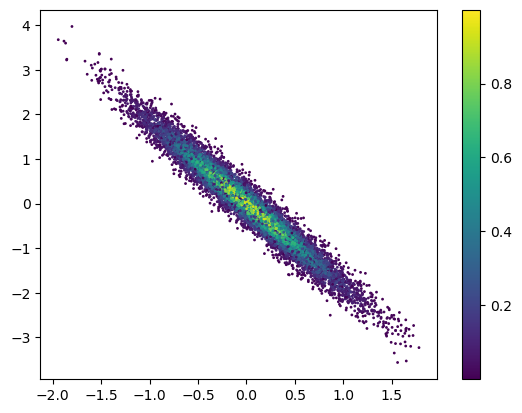

In [49]:
# Approximate
t = DIRT([torch.linspace(-7,7,17)]*3, [1,7,7,1], 4.0**torch.arange(-3,4), ExactRatio=False, Ntest=10**4, reference_sigma=0.0, requires_grad=False)
costf = lambda x: -0.5*torch.sum((x @ A)**2, dim=1)
tempered_costf = lambda x, beta_high, beta_low: costf(x)*(beta_high - beta_low)
ev = t.cross(tempered_costf, nswp=1)
print(f"total evals = {ev}")
x = torch.rand(10**5,3)*14-7
# plt.scatter(x[:,0].cpu().detach().numpy(), x[:,1].cpu().detach().numpy(), 1, torch.exp(0.5*(4.0**-4)*costf(x)).cpu().detach().numpy())
# plt.show()
print("error0", torch.mean((torch.sqrt(t.Densities[0].forward(x)).flatten() - torch.exp(0.5*(4.0**-3)*costf(x)))**2) / torch.mean(torch.exp(0.5*(4.0**-3)*costf(x))**2))

# Sample
x = randref(t.Densities[0].reference_sigma, (10**4,3), device=t.Densities[0].U[0].device)
z, lFapp = t.forward(x)
lFex = tempered_costf(z, 4.0**3, 0)
z, lFex, lFapp, rej = mcmc_prune(z, lFex, lFapp)
plt.scatter(z[:,0].cpu().detach().numpy(), z[:,1].cpu().detach().numpy(), 1, torch.exp(lFex).cpu().detach().numpy())
plt.colorbar()
# t.CurrentLayer
# X, Y = torch.meshgrid(torch.linspace(-3,3,99), torch.linspace(-3,3,99))
# plt.contour(X,Y,t.Density0.forward(torch.hstack([X.reshape(-1,1), Y.reshape(-1,1)])).reshape(99,99).detach().numpy(), levels=33)

In [39]:
# import numpy as np
# def ff(x):
#     return np.sqrt(np.sum(x+1, axis=1, keepdims=True))

# def torchnumpy(fun, x):
#     return torch.tensor(fun(x.detach().numpy()))

t = TTSqrDE([torch.linspace(0,49,50)]*3, [1]+2*[40]+[1])
t.cross(lambda x: torch.sqrt(torch.sum(x+1, axis=1, keepdims=True)), tol=1e-6, nswp=3)

X1, X2, X3 = torch.meshgrid(torch.linspace(0,9,10), torch.linspace(0,9,10), torch.linspace(0,9,10))
torch.norm( (t.forward(torch.hstack([X1.reshape(-1,1), X2.reshape(-1,1), X3.reshape(-1,1)]))**(1/2)).reshape(X1.shape) - torch.sqrt(X1+X2+X3+3) )

Cross sweep 0: max_err = 1.000e+00, cum#evals = 82000
Cross sweep 1: max_err = 1.702e-01, cum#evals = 164000
Cross sweep 2: max_err = 4.527e-06, cum#evals = 246000


tensor(0.0002, grad_fn=<LinalgVectorNormBackward0>)